In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Use seaborn's API to set theme and palette (avoids matplotlib style lookup error)
sns.set_theme(style='darkgrid', palette='husl')
%matplotlib inline

In [4]:
df = pd.read_csv('A:\My project\My Idea\health-risk-predictor-ai\Data\dirty_v3_path.csv')  # Update filename

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (30000, 20)


,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,random_notes,noise_col
0,46.0,Male,Diabetes,137.04,135.27,28.90,96.04,6,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05,lorem,-137.057211
1,22.0,Male,Healthy,71.58,113.27,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,ipsum,-11.230610
2,50.0,NaN,Asthma,95.24,NaN,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,ipsum,98.331195
3,57.0,NaN,Obesity,NaN,130.53,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,lorem,44.187175
4,66.0,Female,Hypertension,95.15,178.17,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,lorem,44.831426


In [5]:
df = df.drop(['random_notes', 'noise_col', 'LengthOfStay'], axis=1, errors='ignore')

# Handle Medical Condition: if it's the target, move it; else one-hot encode
if 'Medical Condition' in df.columns:
    print("Unique Medical Conditions:", df['Medical Condition'].unique())
    # Assuming multi-label or primary condition — we'll define targets later

print("\nMissing Values:")
print(df.isnull().sum())

# Fill numeric missing with median, categorical with mode
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.head()

Unique Medical Conditions: ['Diabetes' 'Healthy' 'Asthma' 'Obesity' 'Hypertension' 'Cancer' nan
 'Arthritis']

Missing Values:
Age                  4500
Gender               4500
Medical Condition    4500
Glucose              4500
Blood Pressure       4500
BMI                     0
Oxygen Saturation       0
Cholesterol             0
Triglycerides           0
HbA1c                   0
Smoking                 0
Alcohol                 0
Physical Activity       0
Diet Score              0
Family History          0
Stress Level            0
Sleep Hours             0
dtype: int64


,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours
0,46.0,Male,Diabetes,137.04,135.27,28.90,96.04,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05
1,22.0,Male,Healthy,71.58,113.27,26.29,97.54,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72
2,50.0,Female,Asthma,95.24,138.32,22.53,90.31,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82
3,57.0,Female,Obesity,110.50,130.53,38.47,96.60,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33
4,66.0,Female,Hypertension,95.15,178.17,31.12,94.90,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64


In [7]:
df['Diabetes_Risk'] = ((df['Glucose'] > 126) | (df['HbA1c'] > 6.5)).astype(int)

# Robust Blood Pressure parsing (handles numeric values or 'systolic/diastolic' strings)
def _parse_bp(val):
    if pd.isnull(val):
        return (np.nan, np.nan)
    if isinstance(val, str):
        parts = val.split('/')
        try:
            s = float(parts[0])
        except:
            s = np.nan
        if len(parts) > 1:
            try:
                d = float(parts[1])
            except:
                d = np.nan
        else:
            d = np.nan
        return (s, d)
    else:
        # numeric value -> treat as systolic only
        try:
            return (float(val), np.nan)
        except:
            return (np.nan, np.nan)

bp_parsed = df['Blood Pressure'].apply(_parse_bp)
systolic = bp_parsed.apply(lambda x: x[0])
diastolic = bp_parsed.apply(lambda x: x[1])

# Hypertension if systolic >=140 OR diastolic >=90. If only systolic is present it will be used.
df['Hypertension'] = (((systolic >= 140) | (diastolic >= 90)).fillna(False)).astype(int)

# Option 3: Multi-disease (Diabetes + Hypertension + High Cholesterol)
df['High_Cholesterol'] = (df['Cholesterol'] > 240).astype(int)

# Select targets
target_cols = ['Diabetes_Risk', 'Hypertension', 'High_Cholesterol']
y = df[target_cols]
X = df.drop(target_cols + ['Medical Condition'], axis=1, errors='ignore')

print("Targets defined:", target_cols)

Targets defined: ['Diabetes_Risk', 'Hypertension', 'High_Cholesterol']


In [9]:
if 'Blood Pressure' in X.columns:
    # robust handling: support numeric, "systolic/diastolic" strings, and mixed values
    s = X['Blood Pressure']

    def _split_bp_series(srs):
        # returns DataFrame with columns Systolic_BP and Diastolic_BP
        if srs.dtype == 'O':
            # string-like series: detect entries with '/'
            contains_slash = srs.astype(str).str.contains('/', na=False)
            systolic = pd.Series(np.nan, index=srs.index)
            diastolic = pd.Series(np.nan, index=srs.index)

            if contains_slash.any():
                parts = srs[contains_slash].astype(str).str.split('/', expand=True)
                systolic[contains_slash] = pd.to_numeric(parts.iloc[:, 0], errors='coerce')
                if parts.shape[1] > 1:
                    diastolic[contains_slash] = pd.to_numeric(parts.iloc[:, 1], errors='coerce')

            # for entries without a slash, try numeric conversion and treat as systolic
            no_slash = ~contains_slash
            if no_slash.any():
                systolic[no_slash] = pd.to_numeric(srs[no_slash], errors='coerce')

            return pd.concat([systolic.rename('Systolic_BP'), diastolic.rename('Diastolic_BP')], axis=1)
        else:
            # numeric dtype: treat value as systolic
            systolic = pd.to_numeric(srs, errors='coerce')
            diastolic = pd.Series(np.nan, index=srs.index)
            return pd.concat([systolic.rename('Systolic_BP'), diastolic.rename('Diastolic_BP')], axis=1)

    bp_split = _split_bp_series(s)
    X = pd.concat([X.drop('Blood Pressure', axis=1), bp_split], axis=1)

# Cholesterol Ratio
if all(col in X.columns for col in ['Cholesterol', 'HDL']):
    X['TC_HDL_Ratio'] = X['Cholesterol'] / X['HDL']

# BMI Category
X['BMI_Category'] = pd.cut(X['BMI'], bins=[0, 18.5, 25, 30, 100], 
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Age Group
X['Age_Group'] = pd.cut(X['Age'], bins=[0, 40, 60, 100], labels=['Young', 'Middle', 'Senior'])

# Smoking: Simplify
if 'Smoking' in X.columns:
    # preserve existing numeric 0/1; map strings if present
    X['Smoking'] = X['Smoking'].replace({'Yes': 1, 'No': 0, 'Former': 1}).fillna(0).astype(int)

# Alcohol
if 'Alcohol' in X.columns:
    X['Alcohol'] = X['Alcohol'].replace({'Yes': 1, 'No': 0, 'Occasional': 1, 'Regular': 1}).fillna(0).astype(int)

X.head()

,Age,Gender,Glucose,BMI,Oxygen Saturation,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,Systolic_BP,Diastolic_BP,BMI_Category,Age_Group
0,46.0,Male,137.04,28.90,96.04,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05,135.27,NaN,Overweight,Middle
1,22.0,Male,71.58,26.29,97.54,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,113.27,NaN,Overweight,Young
2,50.0,Female,95.24,22.53,90.31,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,138.32,NaN,Normal,Middle
3,57.0,Female,110.50,38.47,96.60,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,130.53,NaN,Obese,Middle
4,66.0,Female,95.15,31.12,94.90,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,178.17,NaN,Obese,Senior


In [10]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Apply transformation
X_processed = preprocessor.fit_transform(X)
feature_names = (numeric_features + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

print("Processed Shape:", X_processed.shape)

Processed Shape: (30000, 22)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (24000, 22), Test: (6000, 22)


In [12]:
model = MultiOutputClassifier(xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
))

model.fit(X_train, y_train)

print("Model Training Complete")

Model Training Complete



=== Diabetes_Risk ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3503
           1       1.00      1.00      1.00      2497

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

ROC AUC: 1.000


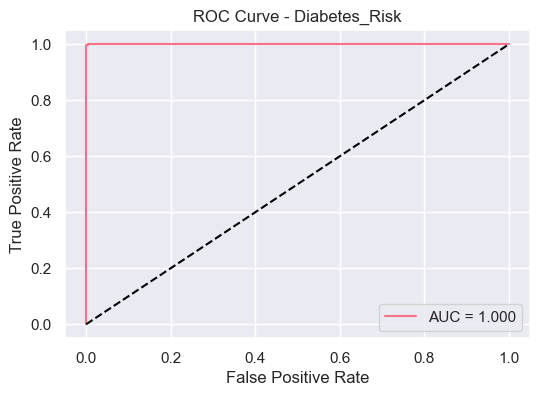


=== Hypertension ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3606
           1       1.00      1.00      1.00      2394

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

ROC AUC: 1.000


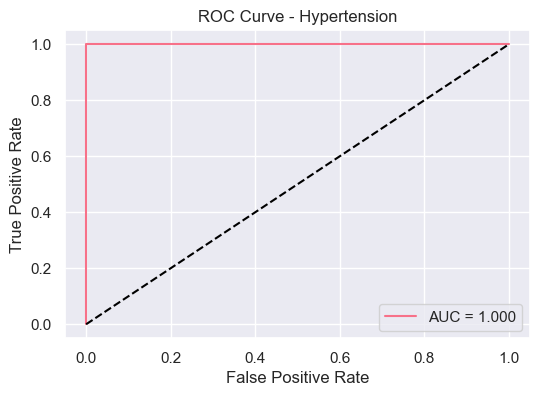


=== High_Cholesterol ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4745
           1       1.00      1.00      1.00      1255

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

ROC AUC: 1.000


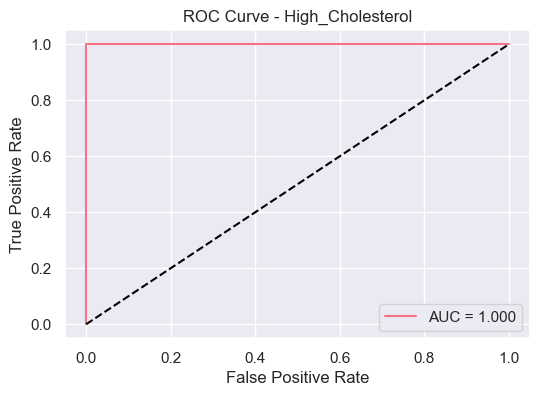

In [14]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

for i, target in enumerate(target_cols):
    print(f"\n=== {target} ===")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))
    
    auc = roc_auc_score(y_test.iloc[:, i], [p[1] for p in y_pred_proba[i]])
    print(f"ROC AUC: {auc:.3f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], [p[1] for p in y_pred_proba[i]])
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {target}')
    plt.legend()
    plt.show()

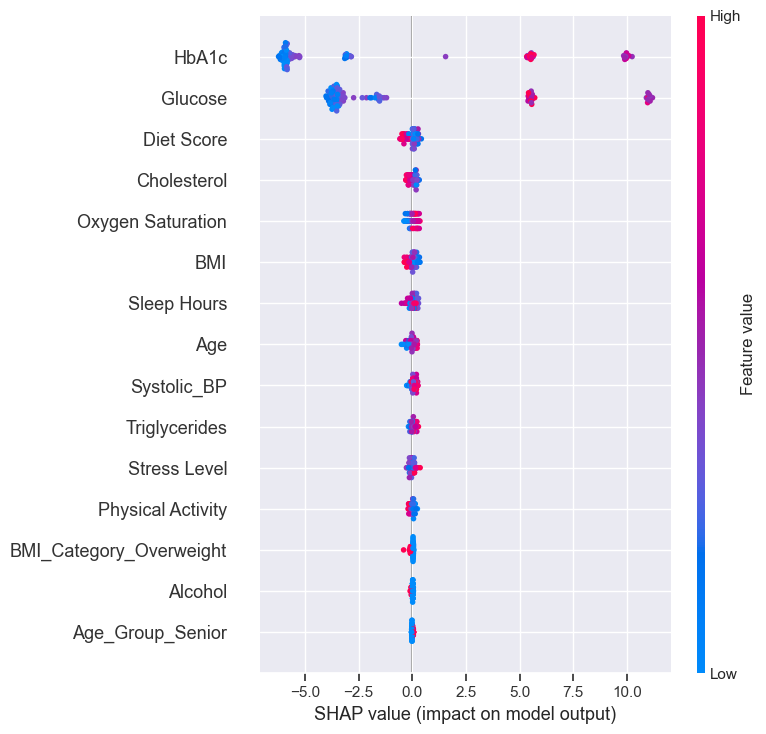

In [13]:
explainer = shap.TreeExplainer(model.estimators_[0])
shap_values = explainer.shap_values(X_test[:100])  # Sample for speed

shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, max_display=15)

In [17]:
def get_recommendations(row, model, preprocessor, feature_names):
    """
    row: can be a numpy array, list, pandas.Series, or pandas.DataFrame of raw features (same cols as X)
    model: trained MultiOutputClassifier
    preprocessor: fitted ColumnTransformer expecting DataFrame with column names
    feature_names: list of processed feature names (not used for indexing raw values)
    """
    # Ensure we pass a DataFrame to the ColumnTransformer (it requires column names when columns specified as strings)
    if isinstance(row, (np.ndarray, list)):
        df_row = pd.DataFrame([row], columns=X.columns)
    elif isinstance(row, pd.Series):
        df_row = row.to_frame().T
    elif isinstance(row, pd.DataFrame):
        df_row = row
    else:
        raise ValueError("Unsupported row type for get_recommendations: must be ndarray/list/Series/DataFrame")

    X_input = preprocessor.transform(df_row)
    proba = model.predict_proba(X_input)
    risks = {target_cols[i]: p[0][1] for i, p in enumerate(proba)}
    
    recs = []
    drivers = []
    
    # Use raw values from df_row for driver checks (more reliable than indexing into processed features)
    bmi_val = pd.to_numeric(df_row.iloc[0].get('BMI', np.nan), errors='coerce')
    hba1c_val = pd.to_numeric(df_row.iloc[0].get('HbA1c', np.nan), errors='coerce')
    
    # Diabetes
    if risks.get('Diabetes_Risk', 0) > 0.6:
        recs.append("Start 150 min/week moderate exercise")
        recs.append("Reduce refined carbs and sugary drinks")
        if not np.isnan(bmi_val) and bmi_val > 30:
            drivers.append("High BMI")
        if not np.isnan(hba1c_val) and hba1c_val > 6.0:
            drivers.append("Elevated HbA1c")
    
    # Hypertension
    if risks.get('Hypertension', 0) > 0.6:
        recs.append("Reduce salt <2g/day")
        recs.append("Monitor BP at home weekly")
    
    # Cholesterol
    if risks.get('High_Cholesterol', 0) > 0.6:
        recs.append("Increase fiber (oats, vegetables)")
        recs.append("Consider plant sterols")
    
    return risks, recs, drivers

# Example
sample = X_test[0]  # processed sample (kept for reference)
# use a raw (unprocessed) row from the original DataFrame (ColumnTransformer expects raw features)
raw_row = X.iloc[0]  # pass a Series (keeps column names)
risks, recs, drivers = get_recommendations(raw_row, model, preprocessor, feature_names)

print("Predicted Risks:", {k: f"{v:.1%}" for k,v in risks.items()})
print("Top Risk Drivers:", drivers)
print("Personalized Recommendations:")
for r in recs[:3]:
    print("  •", r)

Predicted Risks: {'Diabetes_Risk': '100.0%', 'Hypertension': '0.0%', 'High_Cholesterol': '0.0%'}
Top Risk Drivers: ['Elevated HbA1c']
Personalized Recommendations:
  • Start 150 min/week moderate exercise
  • Reduce refined carbs and sugary drinks


In [25]:
import os
import joblib

# Ensure artifacts directory exists before saving
os.makedirs('artifacts', exist_ok=True)

# Save artifacts into artifacts/ directory
joblib.dump(model, 'artifacts/chronic_disease_model.pkl')
joblib.dump(preprocessor, 'artifacts/preprocessor.pkl')
joblib.dump(feature_names, 'artifacts/feature_names.pkl')

print("Model & preprocessor saved!")

Model & preprocessor saved!


In [30]:
def predict_health_risk(input_dict):
    """
    Predicts chronic disease risks (Diabetes, Hypertension, High Cholesterol)
    from user health data using a trained ML model and preprocessing pipeline.

    Input:
        input_dict (dict): Dictionary of raw health features.
            Example:
            {
                'Age': 55,
                'Gender': 'Male',
                'Glucose': 135,
                'HbA1c': 6.3,
                'Blood Pressure': '145/92',
                'BMI': 32,
                'Cholesterol': 245,
                'Triglycerides': 180,
                'Smoking': 'Yes',
                'Alcohol': 'No',
                'Physical Activity': 'Low',
                'Diet Score': 45,
                'Family History': 'Yes',
                'Sleep Hours': 5,
                'Stress Level': 'High'
            }

    Output:
        risks (dict): Probability of each disease risk.
        recs (list): Simple health recommendations based on risk levels.
    """
    import joblib
    import numpy as np
    import pandas as pd

    # Load artifacts (model, preprocessor, feature names)
    try:
        model = joblib.load('artifacts/chronic_disease_model.pkl')
    except FileNotFoundError:
        model = globals().get('model')
        if model is None:
            raise FileNotFoundError("Model not found: artifacts/chronic_disease_model.pkl")

    try:
        preprocessor = joblib.load('artifacts/preprocessor.pkl')
    except FileNotFoundError:
        preprocessor = globals().get('preprocessor')
        if preprocessor is None:
            raise FileNotFoundError("Preprocessor not found: artifacts/preprocessor.pkl")

    try:
        feature_names = joblib.load('artifacts/feature_names.pkl')
    except Exception:
        feature_names = globals().get('feature_names', None)

    # Convert input dict to DataFrame
    df_input = pd.DataFrame([input_dict])

    # --- Step 1: Feature engineering (BP split, BMI/age bins) ---
    def _parse_bp_scalar(val):
        """Convert '120/80' → (120, 80)."""
        import numpy as np, pandas as pd
        if pd.isnull(val):
            return (np.nan, np.nan)
        if isinstance(val, str):
            parts = val.split('/')
            try:
                s = float(parts[0])
            except Exception:
                s = np.nan
            try:
                d = float(parts[1]) if len(parts) > 1 else np.nan
            except Exception:
                d = np.nan
            return (s, d)
        else:
            try:
                return (float(val), np.nan)
            except Exception:
                return (np.nan, np.nan)

    if 'Blood Pressure' in df_input.columns:
        s, d = _parse_bp_scalar(df_input.loc[0, 'Blood Pressure'])
        df_input['Systolic_BP'] = s
        df_input['Diastolic_BP'] = d
        df_input.drop('Blood Pressure', axis=1, inplace=True)

    # Get expected columns from preprocessor
    try:
        expected_cols = list(preprocessor.feature_names_in_)
    except Exception:
        expected_cols = list(df_input.columns)

    # Derived categorical bins
    if 'BMI' in df_input.columns and 'BMI_Category' in expected_cols:
        df_input['BMI_Category'] = pd.cut(
            df_input['BMI'], bins=[0, 18.5, 25, 30, 100],
            labels=['Underweight', 'Normal', 'Overweight', 'Obese']
        )
    if 'Age' in df_input.columns and 'Age_Group' in expected_cols:
        df_input['Age_Group'] = pd.cut(
            df_input['Age'], bins=[0, 40, 60, 100],
            labels=['Young', 'Middle', 'Senior']
        )

    # --- Step 2: Map categorical strings to numeric values ---
    # Smoking & Alcohol
    if 'Smoking' in df_input.columns and 'Smoking' in expected_cols:
        df_input['Smoking'] = df_input['Smoking'].replace(
            {'Yes': 1, 'No': 0, 'Former': 1}
        ).fillna(0).astype(int)
    if 'Alcohol' in df_input.columns and 'Alcohol' in expected_cols:
        df_input['Alcohol'] = df_input['Alcohol'].replace(
            {'Yes': 1, 'No': 0, 'Occasional': 1, 'Regular': 1}
        ).fillna(0).astype(int)

    # Additional categorical mappings
    category_mappings = {
        'Gender': {'Male': 1, 'Female': 0, 'Other': 2},
        'Physical Activity': {'Low': 0, 'Moderate': 1, 'High': 2},
        'Family History': {'Yes': 1, 'No': 0},
        'Stress Level': {'Low': 0, 'Moderate': 1, 'High': 2},
    }
    for col, mapping in category_mappings.items():
        if col in df_input.columns and col in expected_cols:
            df_input[col] = df_input[col].map(mapping).fillna(0).astype(int)

    # --- Step 3: Ensure column alignment and proper dtypes ---
    for c in expected_cols:
        if c not in df_input.columns:
            df_input[c] = np.nan
    
    # Coerce numeric columns to numeric types to avoid object dtypes (which cause np.isnan errors)
    # Use numeric_features from the notebook if available, otherwise infer numeric-like expected cols
    try:
        nf = globals().get('numeric_features', None)
        if nf is None:
            nf = [c for c in expected_cols if c not in globals().get('categorical_features', [])]
    except Exception:
        nf = []
    for col in nf:
        if col in df_input.columns:
            df_input[col] = pd.to_numeric(df_input[col], errors='coerce')
    
    # Ensure categorical columns are string/object dtype so OneHotEncoder / ColumnTransformer can handle them
    try:
        catf = globals().get('categorical_features', None)
        if catf is None:
            # fallback: infer object dtype columns among expected_cols
            catf = [c for c in expected_cols if df_input.get(c) is not None and df_input[c].dtype == 'object']
    except Exception:
        catf = []
    for col in catf:
        if col in df_input.columns:
            # Preserve NaNs, convert non-null entries to string
            df_input[col] = df_input[col].where(df_input[col].isnull(), df_input[col].astype(str))
    
    # Reorder/select expected columns
    df_input = df_input[expected_cols]

    # --- Step 4: Predict ---
    X_proc = preprocessor.transform(df_input)
    proba = model.predict_proba(X_proc)

    # Handle multiple targets
    try:
        tcols = target_cols
    except Exception:
        tcols = ['Diabetes_Risk', 'Hypertension', 'High_Cholesterol']

    risks = {}
    for i, p in enumerate(proba):
        try:
            if hasattr(p, 'shape') and p.shape[1] > 1:
                prob_pos = float(p[0][1])
            else:
                prob_pos = float(p[0])
        except Exception:
            prob_pos = float(np.nan)
        risks[tcols[i]] = prob_pos

    # --- Step 5: Recommendations ---
    recs = []
    if risks.get('Diabetes_Risk', 0) > 0.5:
        recs.append("Monitor blood sugar; consider consulting an endocrinologist.")
    if risks.get('Hypertension', 0) > 0.5:
        recs.append("Reduce salt intake and check BP regularly.")
    if risks.get('High_Cholesterol', 0) > 0.5:
        recs.append("Adopt a heart-healthy diet and exercise regularly.")

    return risks, recs


# --- Example Test ---
test_input = {
    'Age': 55, 'Gender': 'Male', 'Glucose': 135, 'HbA1c': 6.3,
    'Blood Pressure': '145/92', 'BMI': 32, 'Cholesterol': 245,
    'Triglycerides': 180, 'Smoking': 'Yes', 'Alcohol': 'No',
    'Physical Activity': 'Low', 'Diet Score': 45, 'Family History': 'Yes',
    'Sleep Hours': 5, 'Stress Level': 'High'
}

risks, recs = predict_health_risk(test_input)
print("Predicted Risks:", risks)
print("Recommendations:", recs)


Predicted Risks: {'Diabetes_Risk': 0.9998599290847778, 'Hypertension': 0.9998418092727661, 'High_Cholesterol': 0.999599039554596}
Recommendations: ['Monitor blood sugar; consider consulting an endocrinologist.', 'Reduce salt intake and check BP regularly.', 'Adopt a heart-healthy diet and exercise regularly.']
